# Exploration of Nova Bugs

This notebook is part of an overall experiment looking at the ability
to algorithmically (through tuned algorithms and machine learning techniques)
process large backlogs of bugs in Open Source Projects. One of the key 
challenges to maintainer burn out is an ever increasing pile of bugs that
often represent the same or similar issues, and take far too much human
time to keep on top of.

This work is done with the OpenStack Nova project as a starting point because
I've personally looked at 2000 - 4000 of the total 13000 in the backlog over 
the years, so have grounding on what is important and what is not. The intent
is to use this to develop approaches that could be expanded to other projects.

## Bug Processing Pipeline

The bugs for Nova are stored in launchpad. There is an API to extract bugs, 
but it is extremely slow. A extract of the fields required for Nova's 13K bugs takes
6 - 8 hours. As such, an extract is provided in `bugs/nova/2017-10-11` as a series
of json files.

In order to make adhoc query of these bugs easier, they are then loaded into a
`mongodb` database. In order to replicate this notebook you will need to install
mongodb locally. On Ubuntu/Debian Linux this is done with:

```
  sudo apt-get install mongodb
  sudo systemctrl start mongodb
```


In [40]:
# Run this to get a base loaded

import pymongo
from pymongo import MongoClient
import json
import glob

client = MongoClient()

db = client.test_database
bugs = db.bugs
# Drop any existing db to ensure that we don't have data from a past run
bugs.drop()
# Creating this index ensures no duplicate entries can get in
bugs.create_index([('id', pymongo.ASCENDING)], unique=True)


def load_bugs_into_db():
    for file in glob.glob("bugs/nova/2017-10-11/*.json"):
        with open(file) as f:
            bug = json.loads(f.read())
            bugs.insert_one(bug)
            
load_bugs_into_db()
bugs.count()

13236

In [ ]:
%matplotlib inline
import pandas as pd

# Make a query to the specific DB and Collection
cursor = bugs.find()

# Expand the cursor and construct the DataFrame
df =  pd.DataFrame(list(cursor))

df.head()
df['created'] =  pd.to_datetime(df['created'])
df.head()
df.index = df['created']
df.head()

In [101]:
df2 = df.resample('w').count()[['id']]
df2.describe()

,id
count,392.000000
mean,33.765306
std,17.100456
min,0.000000
25%,23.000000
50%,32.000000
75%,44.000000
max,89.000000


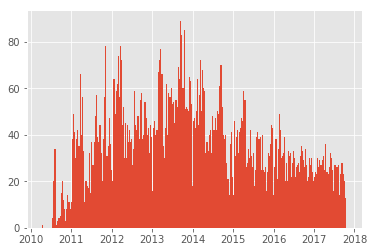

In [102]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as dates
matplotlib.style.use('ggplot')

# Do a dateplot of the bugs to ensure that we're not missing anything, these are binned by week.

ax = plt.subplot()
ax.bar(df2.index.to_pydatetime(), df2.id, width=10)
ax.xaxis_date()

In [104]:
# Make a query to the specific DB and Collection
cursor = bugs.find()

# Expand the cursor and construct the DataFrame, we need to do some unrolling because tags are nested
all_bugs = list(cursor)
all_tags = []
for bug in all_bugs:
    for tag in bug['tags']:
        all_tags.append(
            {"created": bug["created"],
             "tag": tag,
             "id": bug["id"]}
        )
df_tags = pd.DataFrame(all_tags)
df_tags.head()

,created,id,tag
0,2015-11-18 08:43:56.990077+00:00,1517367,xenserver
1,2013-08-24 01:33:20.672518+00:00,1216176,api
2,2012-08-24 01:18:12.859503+00:00,1040956,quantum
3,2017-02-02 10:04:09.662955+00:00,1661195,api
4,2013-12-09 17:45:15.504424+00:00,1259262,api


In [108]:
df_tags.count()
df_tag_counts = df_tags.tag.value_counts()
print(df_tag_counts.head())
df_tag_counts.describe()

api        727
libvirt    687
compute    492
network    403
vmware     403
Name: tag, dtype: int64


count    866.000000
mean      13.047344
std       52.785366
min        1.000000
25%        1.000000
50%        1.000000
75%        4.000000
max      727.000000
Name: tag, dtype: float64